Analysis
========

This is my first pass at actually doing some real analysis on the curling data pulled from the WCF. I'm going to just use the aggregate data that I've built up before (no accuracy for this), and see what I can figure out. This will probably be pretty rough around the edges...

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy
import pandas
import seaborn

seaborn.set(style='whitegrid', palette='colorblind')

In [2]:
import wcf

t = wcf.Tournament(555)
t.load_all_games()

pulling data from results.worldcurling.org...


Sorry, forgot that I already have the data saved... We can use that JSON data to build up our features and train our model.

In [3]:
import json

with open('../data/555.json', 'r') as f:
    data = json.load(f)

print(len(data))
print(data[-1])

71
[{'won': False, 'game-type': 'Final', 'blank': 6, 'total-score': 3, 'total-ends': 9, 'team-name': 'Denmark', 'steal': 0, 'stolen-points': 0, 'blank-with-hammer': 1, 'score-with-hammer': 2, 'score-2+-with-hammer': 1}, {'won': True, 'game-type': 'Final', 'blank': 3, 'total-score': 5, 'total-ends': 9, 'team-name': 'Canada', 'steal': 0, 'stolen-points': 0, 'blank-with-hammer': 3, 'score-with-hammer': 3, 'score-2+-with-hammer': 2}]


First, let's build a dataframe of the data, then separate things out from there. We will have to add in an identifier for the games so that we can use that as a referene. I'm thinking 555070 would be the final game above, so TournamentID-GameIndex should work, and would be unique across all of the data.

In [4]:
for i, game in enumerate(data):
    index = int('555{:03d}'.format(i))
#     print(index)
    game[0]['index'] = index
    game[1]['index'] = index

# for game in data:
#     print(game[0]['index'])

In [5]:
data_flat = [t for game in data for t in game]
print(len(data_flat))

142


In [6]:
cols = ['index', 'game-type', 'team-name', 'total-score', 'total-ends', 'blank', 'blank-with-hammer',
        'score-with-hammer', 'score-2+-with-hammer', 'steal', 'stolen-points', 'won']
df = pandas.DataFrame(data_flat,
                      columns=cols)
df.set_index('index', inplace=True)

In [7]:
df.describe()

,total-score,total-ends,blank,blank-with-hammer,score-with-hammer,score-2+-with-hammer,steal,stolen-points
count,142.000000,142.000000,142.000000,142.000000,142.000000,142.000000,142.000000,142.000000
mean,5.901408,9.028169,4.514085,0.830986,2.985915,1.528169,0.697183,0.992958
std,2.479161,1.438792,1.412889,1.031228,0.974759,1.015439,0.922450,1.441515
min,1.000000,6.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,4.000000,8.000000,4.000000,0.000000,2.000000,1.000000,0.000000,0.000000
50%,6.000000,9.000000,5.000000,1.000000,3.000000,2.000000,0.000000,0.000000
75%,8.000000,10.000000,6.000000,1.000000,4.000000,2.000000,1.000000,2.000000
max,12.000000,11.000000,8.000000,5.000000,5.000000,4.000000,4.000000,8.000000


In [8]:
df.head()

,game-type,team-name,total-score,total-ends,blank,blank-with-hammer,score-with-hammer,score-2+-with-hammer,steal,stolen-points,won
index,,,,,,,,,,,
555000,Draw #1,Sweden,8,10,4,1,3,2,2,3,True
555000,Draw #1,Japan,5,10,6,1,3,2,0,0,False
555001,Draw #1,Korea,3,8,6,0,2,1,0,0,False
555001,Draw #1,Scotland,9,8,2,2,3,3,1,3,True
555002,Draw #1,Norway,11,8,2,2,3,3,1,3,True


In [9]:
winners = df[df['won'] == True]
losers = df[df['won'] == False]

assert len(winners) == len(losers)

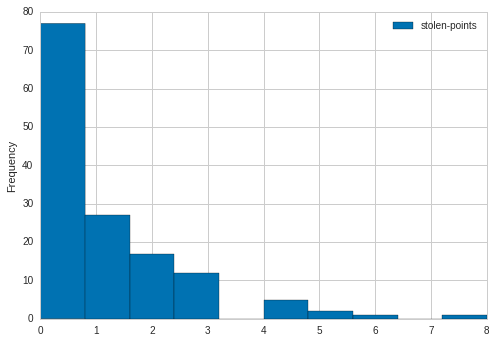

In [10]:
df.plot(x='total-ends', y='stolen-points', kind='hist')
plt.show()

In [11]:
from matplotlib.colors import ListedColormap

def plot_decision_regions(x, y, classifier, test_idx=None, resolution=0.02):
    markers = ('s', 'o', '^', 'v', 'x')
    colors = ('#009E73', '#D55E00', '#CC79A7', '#F0E442', '#56B4E9')
    cmap = ListedColormap(colors[:len(numpy.unique(y))])
    
    x1_min, x1_max = x[:, 0].min() - 1, x[:, 0].max() + 1
    x2_min, x2_max = x[:, 1].min() - 1, x[:, 1].max() + 1
    xx1, xx2 = numpy.meshgrid(numpy.arange(x1_min, x1_max, resolution),
                              numpy.arange(x2_min, x2_max, resolution))
    z = classifier.predict(numpy.array([xx1.ravel(), xx2.ravel()]).T)
    z = z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    
    for idx, cl in enumerate(numpy.unique(y)):
        plt.scatter(x=x[y == cl, 0], y=x[y == cl, 1],
                    alpha=0.8, c=cmap(idx), marker=markers[idx], label=cl)
    
    if test_idx:
        x_test, y_test = x[test_idx, :], y[test_idx]
        plt.scatter(x_test[:, 0], x_test[:, 1], c='', alpha=1.0, linewidths=1, marker='o', s=55, label='test set')

In [19]:
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler

# adjust this to look at different variables
# x = df[['total-score', 'total-ends', 'blank', 'blank-with-hammer',
#         'score-with-hammer', 'score-2+-with-hammer', 'steal', 'stolen-points']]
x = df[['total-score', 'stolen-points']]
y = df['won']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)

x_combined = numpy.vstack((x_train, x_test))
y_combined = numpy.hstack((y_train, y_test))

OK, we have the same basic stuff as in *Python Machine Learning*, so let's look at some models!

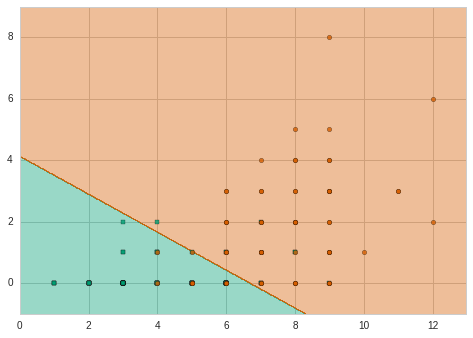

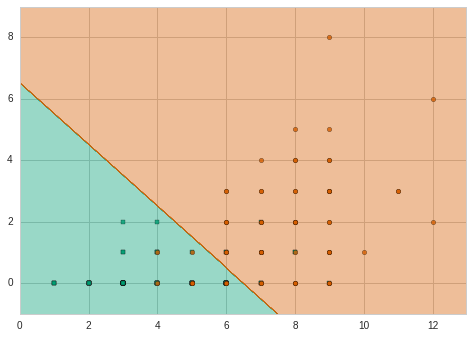

In [20]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(C=1., random_state=0)
model.fit(x_train, y_train)
plot_decision_regions(x_combined, y_combined, classifier=model)
plt.show()

from sklearn.svm import SVC

model = SVC(kernel='linear', C=1.0, random_state=0)
model.fit(x_train, y_train)
plot_decision_regions(x_combined, y_combined, classifier=model)
plt.show()

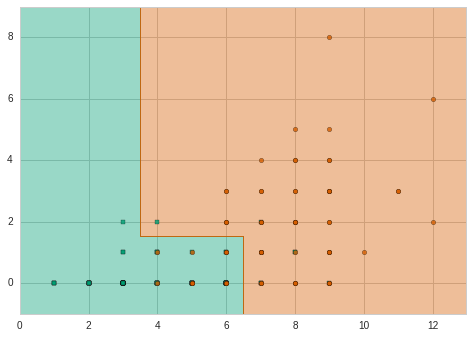

In [21]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=0)
tree.fit(x_train, y_train)
x_combined = numpy.vstack((x_train, x_test))
plot_decision_regions(x_combined, y_combined, classifier=tree)
plt.show()

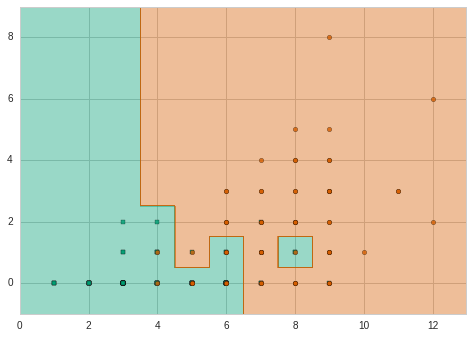

In [22]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(criterion='entropy', n_estimators=10, random_state=1, n_jobs=2)
forest.fit(x_train, y_train)
plot_decision_regions(x_combined, y_combined, classifier=forest)
plt.show()

In [17]:
? seaborn.pairplot

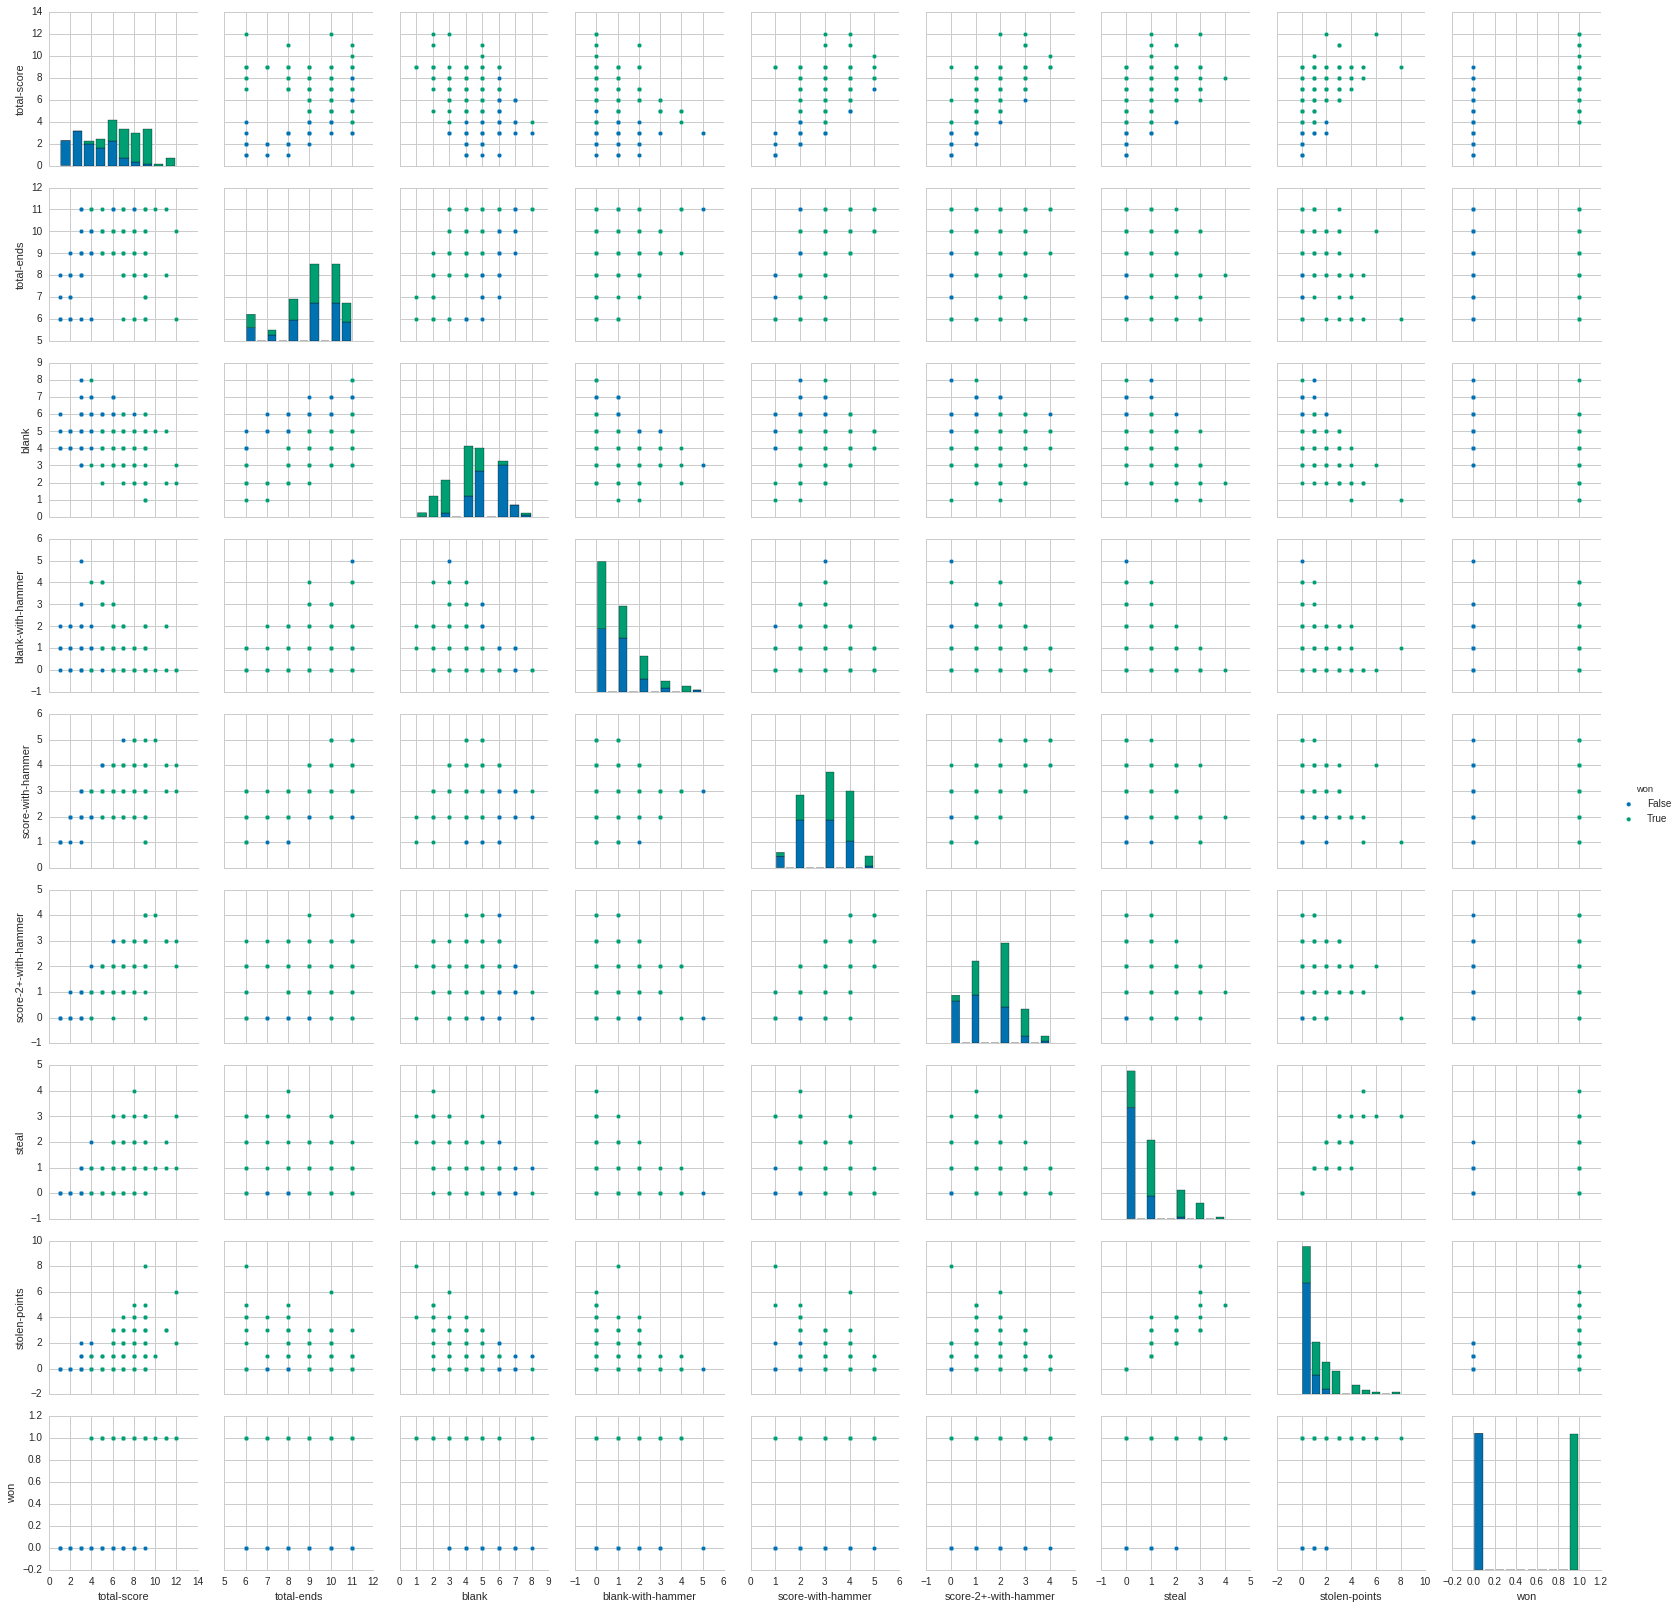

In [18]:
seaborn.pairplot(df, hue='won')
plt.show()